# Workspace for e-chemistry 
This is the workspace for e-chemistry for the B07 and A03 project. The workspace includes CP, CA and CV analysis tools, but they only work with a special file format.
The CP class can be used from the Elias Klemm group of the University of Stuttgart and the CA and CV project from the Kristina Tschulik group of the University of Bochum.

# Packages for the Analysis tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from scipy.optimize import curve_fit
#import scipy.integrate as spi
from sdRDM import DataModel
from tabulate import tabulate
from scipy.integrate import trapz
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual




################################################################
#imports the Analysis tools from the subfolder functions. They are in a Py file called Analysis
from functions.Analysis import Analysis,ChronoPotentiometry,MultiChronoPotentiometry,ChronoAmperometry,MultiChronoAmperometry,CyclicVoltammetry


# Datamodel from GitHub
The following cell loads the Datamodel from GitHub and stores it in the variable lib. The working with a Datamodel is until now (05.05.2023) only a β-phase. In future versions the working with a Datamodel gets more features.

In [3]:

lib = DataModel.from_markdown("specifications/Electrochemistry.md")
e_chem=lib.Dataset()
#lib=DataModel.from_git(url="https://github.com/FAIRChemistry/datamodel-electrochemistry.git")

In [4]:

#e_chem.analysis = [cp]

#e_chem.electrode_setup=lib.ElectrodeSetup(CE="Pt",RE="Hg/HgO",RE_salt="KCl",RE_salt_concentration=1,RE_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
#experiment1=lib.Experiment(experiment_name="Cu12",experiment_filename="Cu12nm.DTA")
#e_chem.experiments=model.Experiment(experiment_name="test")
#e_chem.add_to_experiments([])
#lib.CP(cp_experiments=[lib.Experiment(experiment_name="exp1",experiment_filename="test.txt"),lib.Experiment(experiment_name="exp2",experiment_filename="test2.txt")])
#e_chem.experiments=[experiment1]



# analysis1=lib.Analysis(cp=[cp1,cp2])
# analysis2=lib.Analysis(ca=[cp1,cp2])
#cp_experiments=[lib.Experiment(experiment_name="exp1",experiment_filename="test.txt"),lib.Experiment(experiment_name="exp2",experiment_filename="test2.txt")]
# e_chem.analysis=analysis1
# e_chem.analysis=analysis2
#print(e_chem.analysis.yaml())

In [3]:
experiment1=lib.Experiment(name="Cu12",filename="data/Cu12nm.DTA",type=lib.enums.Experiment_type.CP.value)
experiment2=lib.Experiment(name="Cu14",filename="data/Cu14nm.DTA",type=lib.enums.Experiment_type.CP.value)
#e_chem.experiments.append([experiment1,experiment2])
e_chem.solvent=("H$_2$O")
e_chem.conducting_salt=("KOH")
e_chem.conducting_salt_concentration=(1)
e_chem.conducting_salt_concentration_unit=(lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments=[experiment1,experiment2]
#print(e_chem.experiments)
e_chem.experiments[0].electrode_setup=lib.ElectrodeSetup(counter_electrode="Pt",reference_electrode="Hg/HgO",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[1].electrode_setup=lib.ElectrodeSetup(counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[0].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR)
e_chem.experiments[1].electrolyte=lib.Electrolyte(solvent="MeCN",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR)

In [4]:
cp1=lib.CP(induced_current_first=[1],induced_current_unit=lib.enums.CurrentUnits.AMPERE)
lib.Analysis(cp=cp1)
#lib.Dataset(analysis_methode=Analysis(cp1))

Analysis(id='analysis0', cv=None, ca=None, cp=CP(id='cp0', induced_current=[], induced_current_unit='A', induced_current_second=None, time_duration=None, potential_end_value=None, charge_density=[], cp_experiments=[]))

In [14]:
print(e_chem.json())
#print(e_chem.experiments[1].electrode_setup)

{
  "id": "dataset0",
  "solvent": "H$_2$O",
  "conducting_salt": "KOH",
  "conducting_salt_concentration": 1.0,
  "conducting_salt_concentration_unit": "M",
  "experiments": [
    {
      "id": "experiment6",
      "name": "Cu12",
      "filename": "data/Cu12nm.DTA",
      "electrode_setup": {
        "id": "electrodesetup4",
        "reference_electrode": "Hg/HgO",
        "reference_electrode_salt": "KCl",
        "reference_electrode_salt_concentration": 1.0,
        "reference_electrode_salt_concentration_unit": "M"
      },
      "electrolyte": {
        "id": "electrolyte3",
        "solvent": "H$_2$O",
        "conducting_salt": "KOH",
        "conducting_salt_concentration": 1.0,
        "conducting_salt_concentration_unit": "M"
      },
      "type": "CP"
    },
    {
      "id": "experiment7",
      "name": "Cu14",
      "filename": "data/Cu14nm.DTA",
      "electrode_setup": {
        "id": "electrodesetup5",
        "reference_electrode": "Ag/AgCl",
        "reference_elec

/home/dimitrios/.local/lib/python3.10/site-packages/sdRDM/base/datamodel.py:213: UserWarning: No 'URL' and 'Commit' specified. This model might not be re-usable.
  warnings.warn(


<IPython.core.display.Javascript object>

# Change the style and parameter of the plots
The following cell is not needed only if you want to change some parameters of your plots

In [23]:
plt.rcParams.update({
    'figure.figsize': (6.4,4.8),     # 4:3 aspect ratio. You can change the figure size here
    'font.size' : 12,                   # Set font size to 12pt
    'axes.labelsize': 12,               # -> axis labels
    'legend.fontsize': 12,              # -> legends
    'font.family': 'serif',             # -> font family 
    'text.usetex': False,              # Latex plot rendering. If True,your plots will be rendered with Latex. But this needs extra time for rendering
     'text.latex.preamble':            # LaTeX preamble
         r'\usepackage{mlmodern}'
         #... more packages if needed
})
####################

#plt.style.use('ggplot') # You can choose ure matplotlib style

# If you prefere plotstyle like Origin use the following code:

In [44]:
##### """" For Plotstyle like Origin:
# from matplotlib import  cycler
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Verdana', 'DejaVu Sans']
# plt.rcParams['font.size'] = 15
# plt.rcParams['axes.linewidth'] = 1.1
# plt.rcParams['axes.labelpad'] = 5.0
# plot_color_cycle = cycler('color', [ '0000FE', 'FE0000', '008001', 'FD8000', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf','000000'])
# plt.rcParams['axes.prop_cycle'] = plot_color_cycle
# plt.rcParams['axes.xmargin'] = 0
# plt.rcParams['axes.ymargin'] = 0

# Analytic tools
## Analysis class 
The Analysis class includes a list of different reference potentials and a reference_difference function. This can be used to calculate the difference between two reference potentials. The reference_difference function needs 2 strings from the reference_list() as input. If the RHE scale is involved, a new windows pops up and you need also to enter the pH value.

In [35]:
Ana=Analysis()
Ana.reference_list()
Ana.reference_difference("SHE","RHE")

Reference              Potential (V)
-------------------  ---------------
SHE                            0
RHE                           -0.059
Calomel (sat. KCl)             0.241
Calomel (3.5 M KCl)            0.25
Calomel (1 M KCl)              0.28
Calomel (0.1 M KCl)            0.334
Ag/AgCl (sat. KCl)             0.199
Ag/AgCl (3.5 M KCl)            0.205
Hg/HgO (1 M KOH)               0.14
Hg/HgO (0.1 M KOH)             0.165
Fc/Fc+                         0.4


0.0592

# Input of your metadata
The following is an example how you store your information for a measurement. It is necessary for the plot and calculation functions. GSTATIC(Potentiostat).DTA is the filename which are in the subfolder data. If your file is somewhere else you need to give the full path as input. Windows makes a lot of problems in terms of working with paths. I highly recommend you to store your data in the data subfolder. Linux and MacOs should't make any problems. 

In [121]:
cp_sample1=lib.DatasetForPlots(filename="data/Cu14nm.DTA",reference="Hg/HgO",name="Cu 12 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")


print your stored data with:


In [8]:
cp_sample1.__dict__

{'id': 'datasetforplots0',
 'filename': 'data/Cu12nm.DTA',
 'reference': 'Hg/HgO',
 'name': 'Cu 12 nm',
 'conducting_salt': 'KOH',
 'concentration': '0.1 M',
 'solvent': 'H$_2$O',
 'pH': 'pH 10',
 'scan_rate': None,
 'substrate': None}

# ChronoPotentiometry class/ ChronoPotentiometry(metadata,change_reference=False)
This class needs the metadata from above as input. You also have the choice to change your reference system by setting change_reference=True. A windows opens up and you need to give the reference difference as input and the new reference name. By doing this all your Potential values will be changed to the new system.

In [122]:
cp_normal=ChronoPotentiometry(cp_sample1)


In [10]:
cp_change_ref=ChronoPotentiometry(cp_sample1,change_referene=False)

The CP class has the following functions:
- quick_plot() -> shows all relevant data: $U$ vs time, $I$ vs. time and $U$ of the mess cell vs time. It is only to check if your data looks good or not
- plot(save=False,label=False) -> return a plot $U$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

In [7]:
cp_normal.quick_plot()

NameError: name 'cp_normal' is not defined

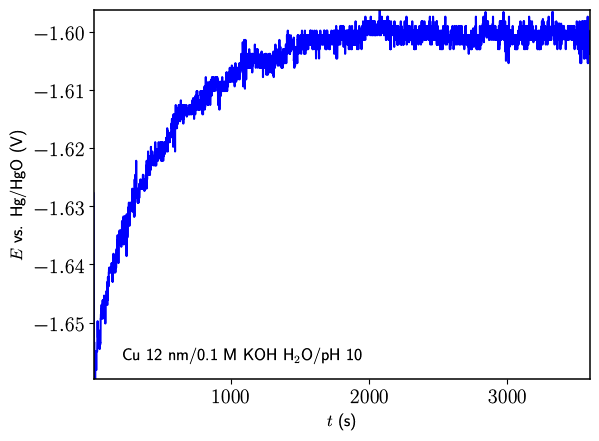

In [34]:
cp_normal.plot()
#cp_change_ref.plot()
#change the axis labels:
#cp_normal.plot(label=True)
#save it with:
#cp_normal.plot(save=True)

determine the last potential with end_value(), which return the average of the last 20 values of your measurement or with end_value_fit() which determines it via a fit function.
The end_value_fit() can be better for oscillating measurements data

/home/dimitrios/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


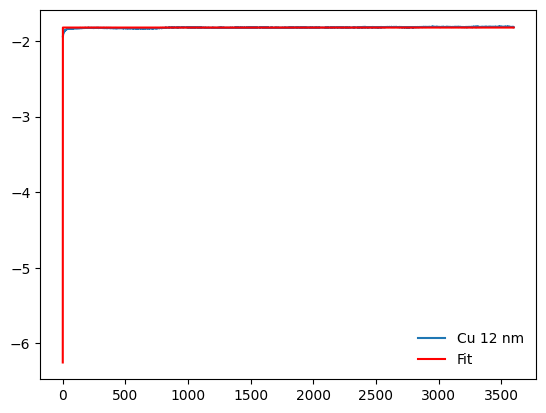

-1.8212116666666414

In [123]:
#cp_normal.end_value()
cp_normal.end_value_fit()
#cp_change_ref.end_value_fit()

# MultiChronoPotentiometry class/ MultiChronoPotentiometry([metadata,metadata2],change_reference=False)
The MultiCP class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same change_reference attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions.


In [31]:
cp_sample2=lib.DatasetForPlots(filename="data/Cu14nm.DTA",reference="Hg/HgO",name="Cu 14 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")

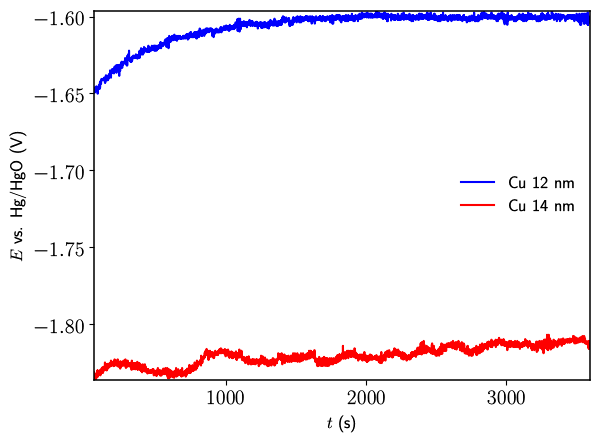

In [36]:
multicp=MultiChronoPotentiometry([cp_sample1,cp_sample2])
multicp.plot(save=False)

# ChronoAmperometry class/ ChronoAmperometry(metadata,current_density=False)
This class is very similar to the ChronoPotentiometry class it has the same input but another attribute current_density=False. By setting this on True you will be able to work with the current density instead of the current.

In [10]:
ca_sample1=lib.DatasetForPlots(filename="data/CA.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7")
ca_sample2=lib.DatasetForPlots(filename="data/CA1.dat",reference="Ag/AgCl",name="PtMe",conducting_salt="LiCLO4",concentration="5 mM",solvent="H$_2$O",)

In [11]:
ca=ChronoAmperometry(ca_sample2,current_density=True)

The CA class has the following functions:
- plot(save=False,label=False) -> return a plot $I$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

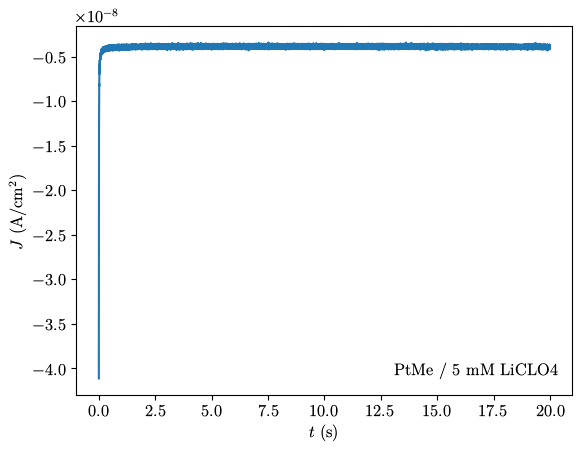

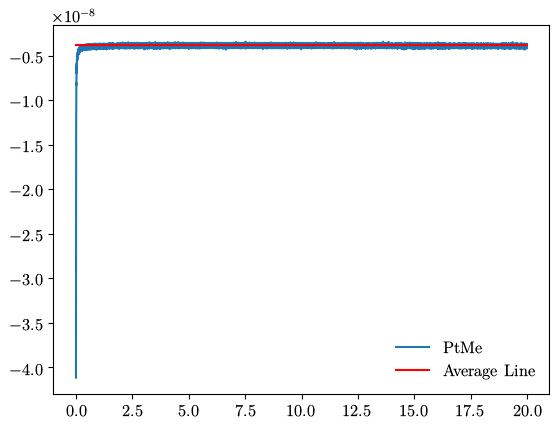

-3.796379999999999e-09

In [13]:
ca.plot()
ca.end_value(save=False)
#ca.end_value_fit()

# MultiChronoAmperometry class/ MultiChronoAmperometry([metadata,metadata2],change_reference=False)
The MultiChronoAmperometry class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same current_density attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions. It is similar to the MultiChronoPotentiometry class.

In [9]:
# multica=MultiChronoAmperometry([ca_sample2])
# multica.plot()

# CyclicVoltammetry class
## CyclicVoltammetry(metadata,[cycles]=None,change_reference=False,current_density=False)
The CyclicVoltammetry class is for Cyclic Voltammetry and needs also a metadata as input. An optional input are the cycles as a list. If you don't give a cycle as input then all cycles will be used. It has also the change_reference and current_density attributes as previously mentioned. The functions are:
- plot(legendposition(x,y),save=False,label=False)
- peaks(range=None) # By default it will be used the whole electrochemical windows, but you can put a range here.
- integration() # This integrates the for- and back cycle separately


In [142]:
cv_sample=lib.DatasetForPlots(filename="data/CV.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7",substrate="Au",scan_rate="20 mV/s")

In [10]:
cv=CyclicVoltammetry(cv_sample,[1],change_reference=False)

#cv.integration()

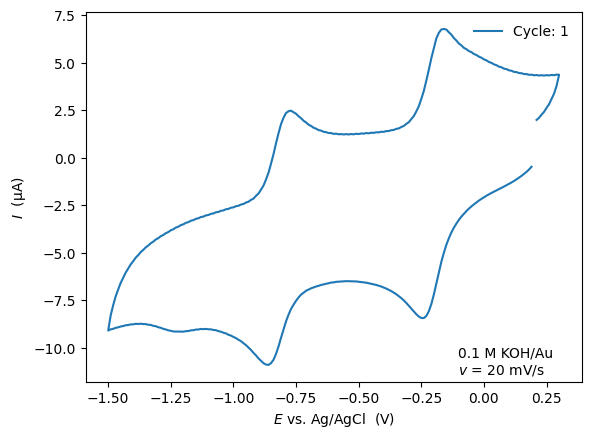

In [11]:
cv.plot()
peaks1=cv.peaks((-1,-0.5))
peaks2=cv.peaks((-0,5,-0))

In [12]:
peaks1


,Cycles,E min,E max,I min,I max,E1/2,I_vertex
0,Cycle: 1,-0.859417,-0.769495,-10.9003,2.47754,-0.814456,-8.61851


In [36]:
peaks2

,Cycles,E min,E max,I min,I max,E1/2,I_vertex
0,Cycle: 1,0.000117,0.000117,-2.07976,5.17299,0.000117,-8.61851


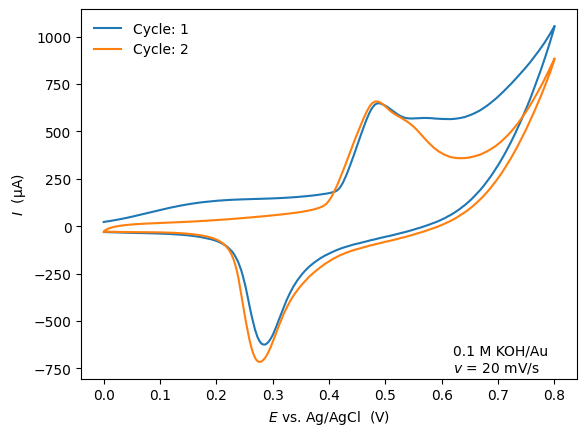

In [5]:
#from sklearn.linear_model import LinearRegression
cv_sample=lib.DatasetForPlots(filename="data/CV.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7",substrate="Au",scan_rate="20 mV/s")
class CyclicVoltammetry(Analysis):
    def __init__(self,metadata,cycles=None,current_density=False,change_reference=False):
        self.df = pd.read_csv(metadata.filename,header=5,skipfooter=1,engine="python")
        self.total_cycles=len(self.df. columns) // 2
        self.all_cycles_list= [i for i in range(1,self.total_cycles+1)]
        self.solvent = metadata.solvent if metadata.solvent is not None else "MeCN"
        self.cycles= cycles if cycles is not None else self.all_cycles_list
        self.concentration = metadata.concentration if  metadata.concentration is not None else "0.1 M"
        self.conducting_salt =  metadata.conducting_salt if metadata.conducting_salt is not None else " KOH"
        self.substrate= metadata.substrate if metadata.substrate is not None else "Au"
        self.scan_rate= metadata.scan_rate if metadata.scan_rate is not None else "20 mV/s"
        self.reference = metadata.reference if metadata.reference is not None else "Ag/AgCl"
        self.name= metadata.name if metadata.name is not None else "" 
        self.E = ["E" for i in range(self.total_cycles)]
        self.I = ["I" for i in range(self.total_cycles)]
        self.df.columns = [name for pair in zip(self.E, self.I) for name in pair]
        self.num_cycles = int(self.df.shape[1] / 2)
        self.cycle_df = np.array_split(self.df, self.num_cycles, axis=1)
        self.cycles = [cycle-1 for cycle in self.cycles]
        if change_reference:
            delta_E=float(input("Enter the reference differnce: "))
            self.reference= input("Enter the reference name: ")
            for df in self.cycle_df:
                df['E'] = df['E'] + delta_E
        self.xlabel= f"$E$ vs. {self.reference}  (V)"
        self.ylabel= r"$I$  ($\mathrm{\mu}$A)" ### \textmu if latex rendering
        if current_density:
            A=float(input("Enter the WE area:"))
            J_unit= input("Enter the unit of your current density (Use $ symbols for exponent eg. A/cm$^2$ ): ")
            self.df["I"] = self.df["I"] / A
            self.ylabel= f"$J$  ({J_unit}) "
            for df in self.cycle_df:
                df['I'] = df['I'] / A
        #pass
    def plot(self,xy=None,save=False,label=False):
        xy= xy if xy is not None else (0.75,.02)
        fig, ax=plt.subplots()
        xlabel=self.xlabel
        ylabel=self.ylabel
        if label:
            xlabel= input("enter new xlabel: ")
            ylabel= input(r"enter new ylabel: ")
        ax.annotate(f"{self.concentration} {self.conducting_salt}/{self.substrate}\n$v$ = {self.scan_rate}", xy=xy, xycoords="axes fraction")
        for i in self.cycles: 
            ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend(loc="best",frameon=False)
        plt.show()

        if save:
            plotname=input("Enter the name of the plot: ")
            fig.savefig(plotname,bbox_inches='tight')
    def peaks(self,range=None):
        E_min=[]
        E_max=[]
        E_hwp=[]
        Cycles=[]
        I_max=[]
        I_min=[]
        I_vertex_list=[]
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        range= range if range is not None else (x_min,x_max) 
        for i in self.cycles:
            Cycles.append("Cycle: {}".format(i+1))
            indices = np.where((self.cycle_df[i]["E"] >= range[0]) & (self.cycle_df[i]["E"] <= range[1]))[0]
            max_index = indices[np.argmax(self.cycle_df[i]["I"][indices])]
            pot_at_max = self.cycle_df[i]["E"][max_index]
            current_at_max = self.cycle_df[i]["I"][max_index]
            min_index = indices[np.argmin(self.cycle_df[i]["I"][indices])]
            pot_at_min = self.cycle_df[i]["E"][min_index]
            current_at_min = self.cycle_df[i]["I"][min_index]
            max_E= np.argmax(self.cycle_df[i]["E"])
            min_E= np.argmin(self.cycle_df[i]["E"])
            I_at_max_E=self.cycle_df[i]["I"][max_E]
            I_at_min_E=self.cycle_df[i]["I"][min_E]
            I_start=self.cycle_df[i]["I"][0]
            if self.cycle_df[0]["E"][0]< self.cycle_df[0]["E"][10]:
                I_vertex=I_at_max_E-I_start
            else:
                I_vertex=I_at_min_E-I_start
            E_max.append(pot_at_max)
            E_min.append(pot_at_min)
            E_hwp.append((pot_at_max+pot_at_min)/2 )
            I_min.append(current_at_min)
            I_max.append(current_at_max)
            I_vertex_list.append(I_vertex)
            df = pd.DataFrame(list(zip(Cycles,E_min,E_max,I_min,I_max,E_hwp,I_vertex_list)), columns=["Cycles",'E min','E max',"I min","I max","E1/2","I_vertex"])   
        return  df   

    def integration(self):
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(E_min=(x_min-0.1,x_max,0.01),E_max=(x_min,x_max,0.01),E_min_back=(x_min-0.1,x_max,0.01),E_max_back=(x_min,x_max,0.01),savename="integration_plot.pdf",save=False):
            Cycles=[]
            Integral=[]
            #fig, ax =plt.subplots()
            global dataframe_integration
            for i in self.cycles:
                    Cycles.append("Cycle: {}".format(i+1)) 
                    fig,ax=plt.subplots()
                    df=self.cycle_df[i]
                    half= len(df)//2
                    forward_cycle=df.iloc[:half,:]
                    backward_cycle=df.iloc[half:,:]
                    forward_cycle_peak = forward_cycle[(forward_cycle['E'] >= E_min) & (forward_cycle['E'] <= E_max)]
                    #new regression
                    start_value = forward_cycle_peak.iloc[0]['E']
                    end_value = forward_cycle_peak.iloc[-1]['E']
                    forward_slope = (forward_cycle_peak.iloc[-1]['I'] - forward_cycle_peak.iloc[0]['I']) / (end_value - start_value)
                    intercept = forward_cycle_peak.iloc[0]['I'] - forward_slope * start_value
                    def line_func(x):
                        return forward_slope * x + intercept
                    y_pred3 = line_func(forward_cycle_peak['E'].values)
                    area_forward = trapz(forward_cycle_peak['I'] - y_pred3.flatten(), forward_cycle_peak['E'])
                    ax.plot(forward_cycle_peak['E'], y_pred3.flatten(),color="black", linestyle='--')
                    #ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred3.flatten(), where=(forward_cycle_peak['I'] > y_pred3.flatten()), alpha=0.3)
                    ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred3.flatten(), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back
                    def line_func_back(x):
                        return backward_slope * x + intercept_back
                    y_pred2 = line_func_back(backward_cycle_peak['E'].values)
                    area_backward = trapz(backward_cycle_peak['I'] - y_pred2.flatten(), backward_cycle_peak['E'])
                    ax.plot(backward_cycle_peak['E'], y_pred2.flatten(), color='black', linestyle='--')
                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), where=(backward_cycle_peak['I'] > y_pred2.flatten()), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back

                    # def line_func_back(x):
                    #     return backward_slope * x + intercept_back

                    y_pred2 = line_func_back(backward_cycle_peak['E'].values)
                    area_backward = trapz(backward_cycle_peak['I'] - y_pred2.flatten(), backward_cycle_peak['E'])
                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), alpha=0.3)# where=(backward_cycle_peak['I'] < y_pred2.flatten())
   
                    Integral.append((area_forward,area_backward))

                    ax.plot(df["E"],df["I"],label="Cycle: {}".format(i+1))
                    ax.set_xlabel(xlabel)
                    ax.set_ylabel(ylabel)
                    ax.legend(frameon=False)
                    if save:
                        fig.savefig("plots/" +"Cycle{}_".format(i+1)+savename)
                    #ax.set_title("Cycle: {}".format(i+1))
                    dataframe_integration= pd.DataFrame(zip(Cycles,Integral), columns=["Cycles","Integration Area"])
                    #self.interactive_dataframe = dataframe
            return dataframe_integration

        widgets.interact(interactive)
        #return dataframe_integration

cv=CyclicVoltammetry(cv_sample,[1,2])
cv.plot()
#result=cv.integration()


In [15]:
print(dataframe_integration)
#print(result)

     Cycles                            Integration Area
0  Cycle: 1  (21.511618740000017, -0.44335198349999744)
1  Cycle: 2       (50.56917374945, -0.3455534350000027)


# CV Interactive

In [8]:
#from IPython.display import display, HTML
cv_sample=lib.DatasetForPlots(filename="data/SarkarCV_utf8.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7",substrate="Au",scan_rate="20 mV/s")
class CyclicVoltammetry(Analysis):
    def __init__(self,metadata,cycles=None,current_density=False,change_reference=False):
        self.df = pd.read_csv(metadata.filename,header=5,skipfooter=1,engine="python")
        self.total_cycles=len(self.df. columns) // 2
        self.all_cycles_list= [i for i in range(1,self.total_cycles+1)]
        self.solvent = metadata.solvent if metadata.solvent is not None else "MeCN"
        self.cycles= cycles if cycles is not None else self.all_cycles_list
        self.concentration = metadata.concentration if  metadata.concentration is not None else "0.1 M"
        self.conducting_salt =  metadata.conducting_salt if metadata.conducting_salt is not None else " KOH"
        self.substrate= metadata.substrate if metadata.substrate is not None else "Au"
        self.scan_rate= metadata.scan_rate if metadata.scan_rate is not None else "20 mV/s"
        self.reference = metadata.reference if metadata.reference is not None else "Ag/AgCl"
        self.name= metadata.name if metadata.name is not None else "" 
        self.E = ["E" for i in range(self.total_cycles)]
        self.I = ["I" for i in range(self.total_cycles)]
        self.df.columns = [name for pair in zip(self.E, self.I) for name in pair]
        self.num_cycles = int(self.df.shape[1] / 2)
        self.cycle_df = np.array_split(self.df, self.num_cycles, axis=1)
        self.cycles = [cycle -1 for cycle in self.cycles]
        if change_reference:
            delta_E=float(input("Enter the reference differnce: "))
            self.reference= input("Enter the reference name: ")
            for df in self.cycle_df:
                df['E'] = df['E'] + delta_E
        self.xlabel= f"$E$ vs. {self.reference}  (V)"
        self.ylabel= r"$I$  ($\mathrm{\mu}$A)" ### \textmu if latex rendering
        if current_density:
            A=float(input("Enter the WE area:"))
            J_unit= input("Enter the unit of your current density (Use $ symbols for exponent eg. A/cm$^2$ ): ")
            self.df["I"] = self.df["I"] / A
            self.ylabel= f"$J$  ({J_unit}) "
            for df in self.cycle_df:
                df['I'] = df['I'] / A
    def plot(self,xy=None,save=False,label=False):
        xy= xy if xy is not None else (0.75,.02)
        #fig, ax=plt.subplots()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(xlabel=xlabel, ylabel=ylabel,savename="CV_plot.pdf",text_xcoord=0.8,text_ycoord=0.05,annotate_text=widgets.Textarea(value=f"{self.concentration} {self.conducting_salt}/{self.substrate} \n$v$ = {self.scan_rate}"),save=False,annotate=True,legend=True,arrow=True,y_arrow_position=(self.cycle_df[0]['I'].min(),self.cycle_df[0]['I'].max()),arrow_end=15):
            fig, ax = plt.subplots()
            for i in self.cycles: 
                ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
            if legend:
                ax.legend(loc="best",frameon=False)
            if save:
                fig.savefig("plots/" + savename)
            if annotate:
                ax.annotate(annotate_text, xy=(text_xcoord,text_ycoord), xycoords="axes fraction")
                #ax.text(xcoord, ycoord, annotate_text, ha='left', va='bottom', transform=ax.transAxes)
            if arrow:
                ax.arrow(self.cycle_df[0]['E'][0],y_arrow_position, dx=self.cycle_df[0]['E'][arrow_end]-self.cycle_df[0]['E'][0], dy=0, head_width=(self.cycle_df[0]['I'].max()-self.cycle_df[0]['I'].min())/25, head_length=(self.cycle_df[0]['E'].max()-self.cycle_df[0]['E'].min())/14, fc='black', ec='black')
        widgets.interact(interactive,text_xcoord=(0,1.2,0.05),text_ycoord=(0,1.2,0.05),arrow_end=(1,100,1))
    def peaks(self,range=None):
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        #df=pd.DataFrame()
        range= range if range is not None else (x_min,x_max)  
        def interactive(E_Min=x_min,E_Max=x_max,vertex_line=False, E_hwp_average=False): 
            E_min=[]
            E_max=[]
            E_hwp=[]
            E_hwp_mean=[]
            Cycles=[]
            I_max=[]
            I_min=[]
            I_vertex_list=[]
            for i in self.cycles:
                fig, ax=plt.subplots()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
                Cycles.append("Cycle: {}".format(i+1))
                indices = np.where((self.cycle_df[i]["E"] >= E_Min) & (self.cycle_df[i]["E"] <= E_Max))[0]
                max_index = indices[np.argmax(self.cycle_df[i]["I"][indices])]
                pot_at_max = self.cycle_df[i]["E"][max_index]
                current_at_max = self.cycle_df[i]["I"][max_index]
                min_index = indices[np.argmin(self.cycle_df[i]["I"][indices])]
                pot_at_min = self.cycle_df[i]["E"][min_index]
                current_at_min = self.cycle_df[i]["I"][min_index]
                max_E= np.argmax(self.cycle_df[i]["E"])
                min_E= np.argmin(self.cycle_df[i]["E"])
                I_at_max_E=self.cycle_df[i]["I"][max_E]
                I_at_min_E=self.cycle_df[i]["I"][min_E]
                I_start=self.cycle_df[i]["I"][0]
                ax.axvline(x=(pot_at_max+pot_at_min)/2 , color='red', linestyle='--',linewidth=2)
                ax.axvline(x=pot_at_min , color='darkgreen', linestyle=':',linewidth=2)
                ax.axvline(x=pot_at_max , color='orange', linestyle=':')
                ax.legend(frameon=False)
                if self.cycle_df[0]["E"][0]< self.cycle_df[0]["E"][10]:
                #I_vertex=I_at_max_E-I_start
                    I_vertex=I_at_max_E
                else:
                #I_vertex=I_at_min_E-I_start
                    I_vertex=I_at_min_E
                E_max.append(pot_at_max)
                E_min.append(pot_at_min)
                E_hwp.append((pot_at_max+pot_at_min)/2 )
                average_hwp = np.average(E_hwp)
                I_min.append(current_at_min)
                I_max.append(current_at_max)
                I_vertex_list.append(I_vertex)
                if vertex_line:
                    ax.axhline(y=I_vertex , color='black', linestyle='-')
            if E_hwp_average:
                print(average_hwp)
            self.df_peaks = pd.DataFrame(list(zip(Cycles,E_min,I_min,E_max,I_max,E_hwp,I_vertex_list)), columns=["Cycles",'E_at_min',"I min",'E_at_max',"I max","E1/2","I_vertex"])  

            return self.df_peaks  
        widgets.interact(interactive,E_Min=(x_min,x_max),E_Max=(x_min,x_max))
        
        return self.df_peaks
    def integration(self):
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(E_min=(x_min-0.1,x_max,0.01),E_max=(x_min,x_max,0.01),E_min_back=(x_min-0.1,x_max,0.01),E_max_back=(x_min,x_max,0.01),savename="integration_plot.pdf",save=False):
            Cycles=[]
            Integral_forward=[]
            Integral_backward=[]
            for i in self.cycles:
                    Cycles.append("Cycle: {}".format(i+1)) 
                    fig,ax=plt.subplots()
                    df=self.cycle_df[i]
                    half= len(df)//2
                    forward_cycle=df.iloc[:half,:]
                    backward_cycle=df.iloc[half:,:]
                    forward_cycle_peak = forward_cycle[(forward_cycle['E'] >= E_min) & (forward_cycle['E'] <= E_max)]
                    #new regression
                    start_value = forward_cycle_peak.iloc[0]['E']
                    end_value = forward_cycle_peak.iloc[-1]['E']
                    forward_slope = (forward_cycle_peak.iloc[-1]['I'] - forward_cycle_peak.iloc[0]['I']) / (end_value - start_value)
                    intercept = forward_cycle_peak.iloc[0]['I'] - forward_slope * start_value
                    def line_func(x):
                        return forward_slope * x + intercept
                    y_pred3 = line_func(forward_cycle_peak['E'].values)
                    area_forward = trapz(forward_cycle_peak['I'] - y_pred3.flatten(), forward_cycle_peak['E'])
                    ax.plot(forward_cycle_peak['E'], y_pred3.flatten(),color="black", linestyle='--')
                    #ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred3.flatten(), where=(forward_cycle_peak['I'] > y_pred3.flatten()), alpha=0.3)
                    ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred3.flatten(), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back
                    def line_func_back(x):
                        return backward_slope * x + intercept_back
                    y_pred2 = line_func_back(backward_cycle_peak['E'].values)
                    area_backward = trapz(backward_cycle_peak['I'] - y_pred2.flatten(), backward_cycle_peak['E'])
                    ax.plot(backward_cycle_peak['E'], y_pred2.flatten(), color='black', linestyle='--')
                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), where=(backward_cycle_peak['I'] > y_pred2.flatten()), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back

                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), alpha=0.3)# where=(backward_cycle_peak['I'] < y_pred2.flatten())
   
                    Integral_forward.append(area_forward)
                    Integral_backward.append(area_backward)

                    ax.plot(df["E"],df["I"],label="Cycle: {}".format(i+1))
                    ax.set_xlabel(xlabel)
                    ax.set_ylabel(ylabel)
                    ax.legend(frameon=False)
                    if save:
                        fig.savefig("plots/" +"Cycle{}_".format(i+1)+savename)
                    #ax.set_title("Cycle: {}".format(i+1))
                    df= pd.DataFrame(zip(Cycles,Integral_forward,Integral_backward), columns=["Cycles","Integration Area forward","Integration Area backward"])
                    #self.interactive_dataframe = dataframe
            return df

        widgets.interact(interactive)
        #return dataframe_integration

cv=CyclicVoltammetry(cv_sample)
#cv.plot()
test=cv.peaks()
#cv.peaks((-1,-0.5))
#cv.integration()
#print(test)

interactive(children=(FloatSlider(value=-1.49903, description='E_Min', max=0.299962, min=-1.49903), FloatSlide…

interactive(children=(FloatSlider(value=-0.6590300000000001, description='E_min', max=0.299962, min=-1.5990300…

In [16]:
print(test)

     Cycles  E_at_min     I min  E_at_max    I max      E1/2  I_vertex
0  Cycle: 1 -0.859417 -10.90030 -0.159805  6.77707 -0.509611  -9.09213
1  Cycle: 2 -0.859417  -8.52469 -0.159805  7.41890 -0.509611  -6.97401


In [7]:
import ipywidgets as widgets
#from IPython.display import display

x = [0, 1]
y = [1, 3]
#fig, ax= plt.subplots()
def update_plot(z="Title",y_label="y label"):
    plt.title(z)
    plt.ylabel(y_label)
    plt.plot(x, y)

widgets.interact(update_plot)

#plt.plot(x, y)
#plt.show()

interactive(children=(Text(value='Title', description='z'), Text(value='y label', description='y_label'), Outp…

<function __main__.update_plot(z='Title', y_label='y label')>

In [94]:
e_chem.experiments[1].electrode_setup.RE

'Ag/AgCl'

interactive(children=(Text(value='$t$ (s)', description='xlabel'), Text(value='$E$ vs. Hg/HgO (V)', descriptio…

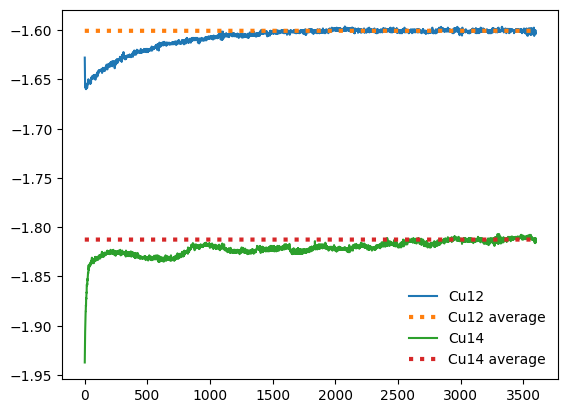

,Name,Average (last 50 point)
0,Cu12,-1.60056
1,Cu14,-1.81256


In [8]:

class ChronoPotentiometry:
    def __init__(self,e_chem,experiment_list,change_reference=False):
        self.reference = e_chem.experiments[experiment_list[0]].electrode_setup.reference_electrode
        self.e_chem = e_chem
        self.experiment_list=experiment_list
        self.df_liste=[]
        for experiment in range(0,len(e_chem.experiments)):
            if e_chem.experiments[experiment].type=="CP":
                df = pd.read_csv(e_chem.experiments[experiment].filename, sep="\t", header=56, skiprows=[57], usecols=[2,3,4,5],names=["t","E","I","V"])
                self.df_liste.append(df)
            else:
                pass
        if change_reference:
            self.delta_E=float(input("Enter the reference differnce: "))
            self.reference= input("Enter the reference name: ")
            for df in self.df_liste:
                df['E'] = df['E'] + self.delta_E
        else:
            pass
    def quick_plot(self):
        for experiment in self.experiment_list:
            f, (ax,ax2,ax3) = plt.subplots(3,1)
            f.suptitle(e_chem.experiments[experiment].name)
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
            ax2.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"])
            ax3.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["V"])
            ax.set_ylabel("$E$ vs Ref (V)")
            ax2.set_ylabel("$I$ (A)")
            ax3.set_ylabel("$V$ (V)")
            ax3.set_xlabel("$t$ (s)")
            ax.get_xaxis().set_visible(False)
            ax2.get_xaxis().set_visible(False)
            
    def plot(self):
        xlabel="$t$ (s)"
        ylabel=f"$E$ vs. {self.reference} (V)"
        def update_plot(xlabel=xlabel, ylabel=ylabel,savename="CP_plot.pdf",xcoord=(0,1.2,0.05),ycoord=(0,1.2,0.05),annotate_text=widgets.Textarea(value=f"{e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt} {e_chem.experiments[self.experiment_list[0]].electrolyte.solvent} \n"),save=False,annotate=True,legend=True):
            fig, ax = plt.subplots() #e_chem.experiments[self.experiment_list[0]].electrolyte.solvent
            for experiment in self.experiment_list: #annotate_text=widgets.Textarea(value=f"{self.concentration} {self.conducting_salt}/{self.substrate} \n$v$ = {self.scan_rate}")
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if legend:
                ax.legend(loc="best",frameon=False)
            if save:
                fig.savefig("plots/" + savename)
            if annotate:
                #ax.annotate((e_chem.solvent),xy=(1.,1),xycoords="axes fraction")
                ax.annotate(annotate_text,xy=(xcoord,ycoord),xycoords="axes fraction")
        widgets.interact(update_plot)
    def end_value_fit(self,save=False):
        def exponential_fit(x, a, b, c):
            return a * np.exp(-b/2 * x) + c
        fig,ax =plt.subplots()
        names=[]
        end_values=[]
        for experiment in self.experiment_list:
            t_fit = np.linspace(0, self.df_liste[experiment].shape[0], self.df_liste[experiment].shape[0])
            popt, pcov = curve_fit(exponential_fit,self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
            c=popt[2]
            names.append(e_chem.experiments[experiment].name)
            end_values.append(c)
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
            ax.plot(t_fit, exponential_fit(t_fit, *popt),linewidth=3,linestyle='dotted', label="{} fit".format(e_chem.experiments[experiment].name))
            ax.legend(loc="best",frameon=False)
            df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","End value"])   
        return  df   
    def end_value(self,save=False):
        fig,ax =plt.subplots()
        names=[]
        end_values=[] 
        for experiment in self.experiment_list:
            last_values = self.df_liste[experiment].tail(100)["E"].values[0]
            average = last_values.mean()
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
            ax.plot(self.df_liste[experiment]["t"], [average] * len(self.df_liste[experiment]["t"]), linewidth=3,linestyle='dotted', label="{} average".format(e_chem.experiments[experiment].name))
            ax.legend(loc="best",frameon=False)
            names.append(e_chem.experiments[experiment].name)
            end_values.append(average) 
            df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","Average (last 50 point)"]) 
        plt.show() 
        if save:
            plotname=input("Enter the name of the plot: ")
            fig.savefig(plotname,bbox_inches='tight')  
        return  df



test=ChronoPotentiometry(e_chem,[0,1],change_reference=False)
test.plot()
#test.quick_plot()
test.end_value()
#test.end_value_fit()

In [8]:
import ipywidgets as widgets
from IPython.display import display

# Erstellen Sie ein Dropdown-Menü mit Zahlen von 1 bis 10
dropdown = widgets.Dropdown(options=list(range(1, 11)))

# Erstellen Sie einen Button zum Bestätigen der Auswahl
button = widgets.Button(description="Auswahl bestätigen")

# Erstellen Sie eine Ausgabefläche zum Anzeigen der ausgewählten Zahl
output = widgets.Output()

# Deklarieren Sie die Variable im globalen Gültigkeitsbereich
selected_number = None

# Funktion, die aufgerufen wird, wenn der Button geklickt wird
def on_button_clicked(b):
    global selected_number
    with output:
        # Speichern Sie die ausgewählte Zahl in der globalen Variable
        selected_number = dropdown.value
        print("Ausgewählte Zahl:", selected_number)
button.on_click(on_button_clicked)

# Zeigen Sie das Dropdown-Menü, den Button und die Ausgabefläche an
display(dropdown, button, output)

Dropdown(options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1)

Button(description='Auswahl bestätigen', style=ButtonStyle())

Output()

In [80]:
print(selected_number)

1


In [22]:
import ipywidgets as widgets
from IPython.display import display

# Die Funktion, die aufgerufen wird, wenn sich der Wert des Widgets ändert
def handle_value_change(value):
    global selected_number
    selected_number = value
    print("Ausgewählte Zahl:", selected_number)

# Verwenden Sie das interact()-Funktion, um die Funktion mit einem Widget zu verknüpfen
widgets.interact(handle_value_change, value=widgets.IntSlider(min=1, max=10, value=1))

# Zeigen Sie das Widget an
display(widgets.IntSlider(min=1, max=10, value=1))

interactive(children=(IntSlider(value=1, description='value', max=10, min=1), Output()), _dom_classes=('widget…

IntSlider(value=1, max=10, min=1)

In [24]:
print(selected_number)

6


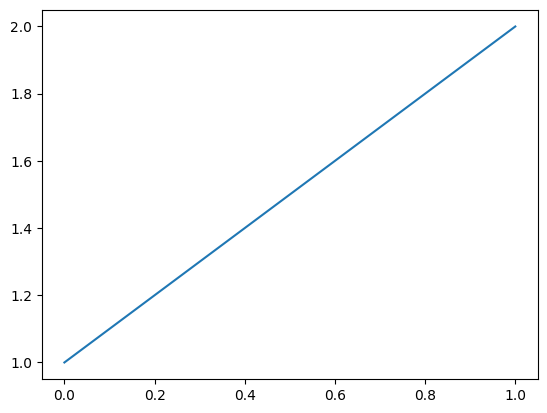

In [5]:
x=[0,1]
y=[1,2]
plt.plot(x,y)

In [93]:
import ipywidgets as widgets
from IPython.display import display

reference_values = {
    "SHE": 0,
    "RHE": -0.059,
    "Calomel (sat. KCl)": 0.241,
    "Calomel (3.5 M KCl)": 0.250,
    "Calomel (1 M KCl)": 0.280,
    "Calomel (0.1 M KCl)": 0.334,
    "Ag/AgCl (sat. KCl)": 0.199,
    "Ag/AgCl (3.5 M KCl)": 0.205,
    "Hg/HgO (1 M KOH)": 0.140,
    "Hg/HgO (0.1 M KOH)": 0.165,
    "Fc/Fc+": 0.400
}

@widgets.interact(x=list(reference_values.keys()), y=list(reference_values.keys()), pH="1", potential="0")
def display_widget(x, y, pH, potential):
    global result
    if x == "RHE" or y == "RHE":
        reference_values["RHE"] = -0.0592 * float(pH)
    result = float(potential) + reference_values[y] - reference_values[x]
    print(result)
    return result

test = display_widget



interactive(children=(Dropdown(description='x', options=('SHE', 'RHE', 'Calomel (sat. KCl)', 'Calomel (3.5 M K…

In [7]:
analysis=Analysis()
#analysis.reference_list()
analysis.reference_difference()


interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

-0.199

In [8]:
print(analysis.reference_difference_value)

0.05099999999999999


In [14]:
test=Analysis()
new=test.reference_difference()
#print(new)

interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

In [35]:


# Beispielaufruf
test = Analysis()
new = test.reference_difference()
#print(new)

interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

-0.199


In [19]:
test = Analysis()
new = test.reference_difference()

interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

In [2]:
test=Analysis()
holla=test.reference_difference()


interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

In [6]:
test.reference_difference_value

0.135